In [1]:
# import data from the web
library(readr)
df <- read_table("http://azzalini.stat.unipd.it/Book-DM/yesterday.dat",
                  col_types = cols( x = col_double(),
                                    y.yesterday = col_double(),
                                    y.tomorrow = col_double())
                  )[-31,]

# create training set
train <- data.frame(x = df$x, y = df$y.yesterday)

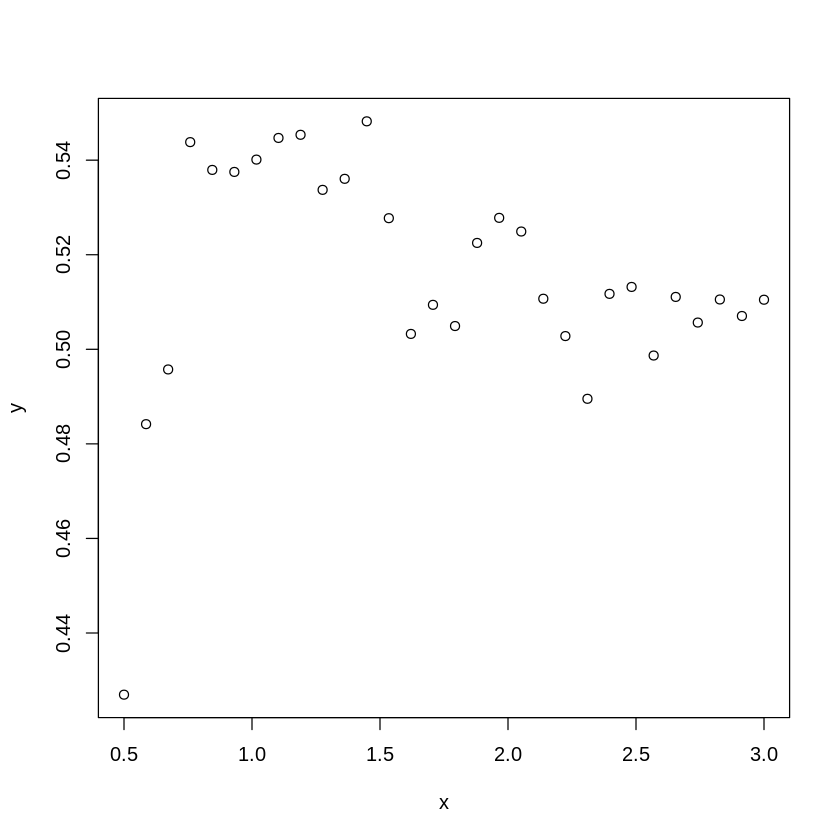

In [2]:
plot(y ~ x, train)

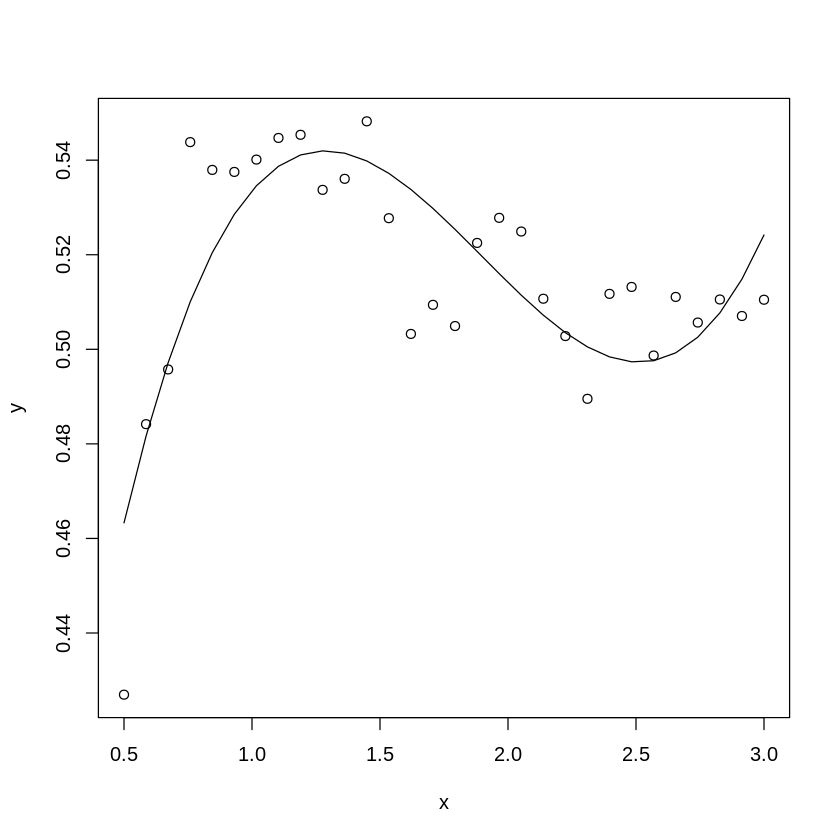

In [3]:
# create test set
test = data.frame(x = train$x, y = df$y.tomorrow)

# 3rd degree polynomial regression fit
fit <- lm( y ~ poly(x, degree = 3), train)
yhat <- predict(fit, newdata = test)

# plot
plot(y ~ x , train)
lines(yhat ~ x, train)

In [4]:
# compute MSE.tr for the 3rd degree polynomial fit
MSE.tr <- mean( (train$y - yhat)^2 )
MSE.tr

[1] 0.0002085353

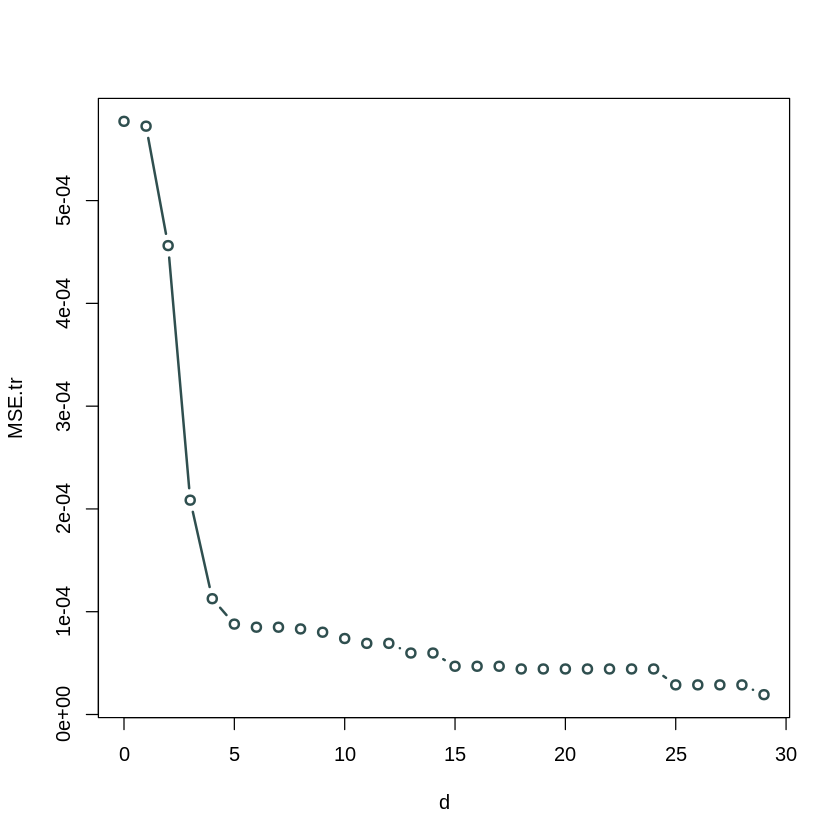

In [5]:
n  <- nrow(train)
ds <- 0:(n-1)
ps <- ds + 1
# function to fit polynomial model of degree d
fun <- function(d) if (d == 0) lm(y ~ 1, train) else
                   lm(y ~ poly(x, degree = d, raw = T), train)
fits <- sapply(ds, fun)       ### list of models

# compute MSE.tr for all degrees
MSEs.tr <- unlist( lapply(fits, deviance) )/n
plot(ds, MSEs.tr, type = "b", xlab = "d", ylab = "MSE.tr",
     col = "darkslategray", lwd=2)

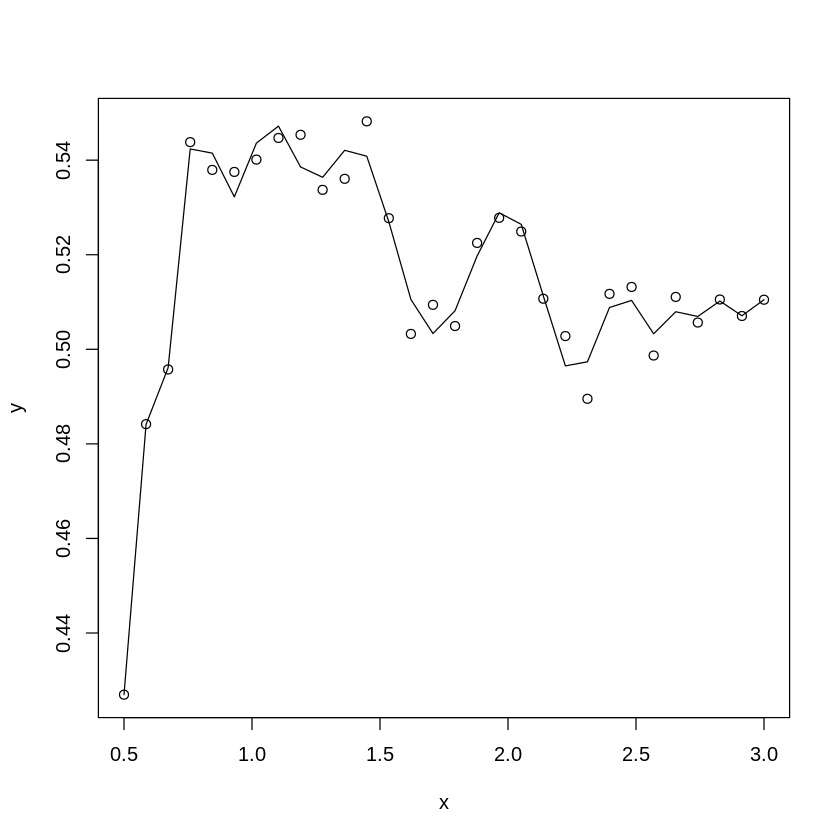

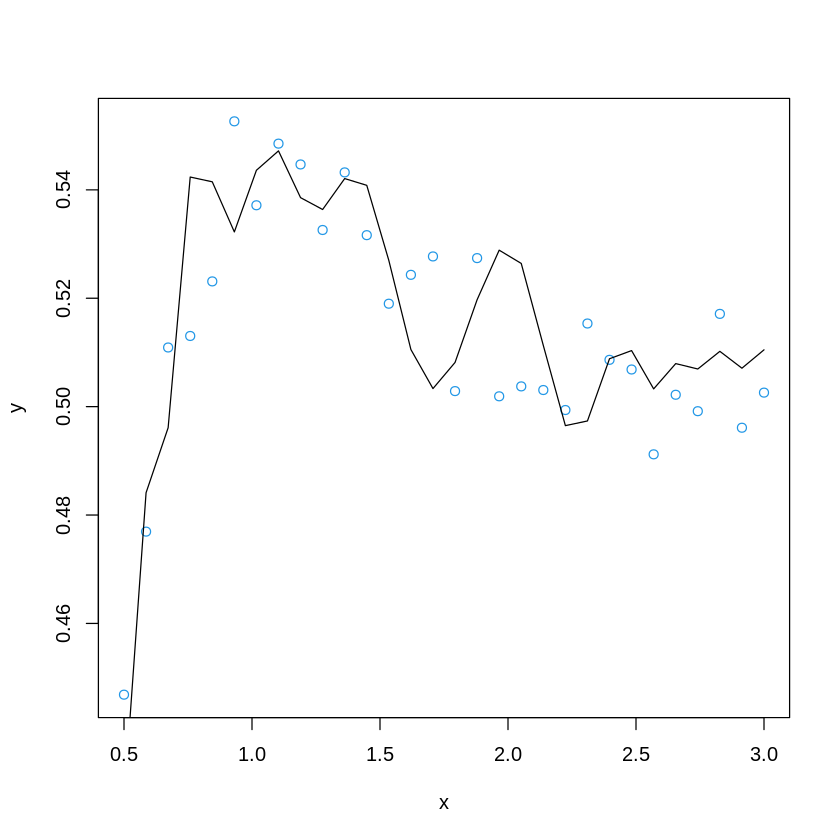

In [6]:
# 20th degree polynomial fit
fit <- lm( y ~ poly(x, degree = 20), train)
yhat <- predict(fit, newdata = test)

# design matrix
X = model.matrix(fit)

# plots
plot(y ~ x, train)
lines(yhat ~ x, train)
plot(y ~ x, test, col = 4)
lines(yhat ~ x, train)

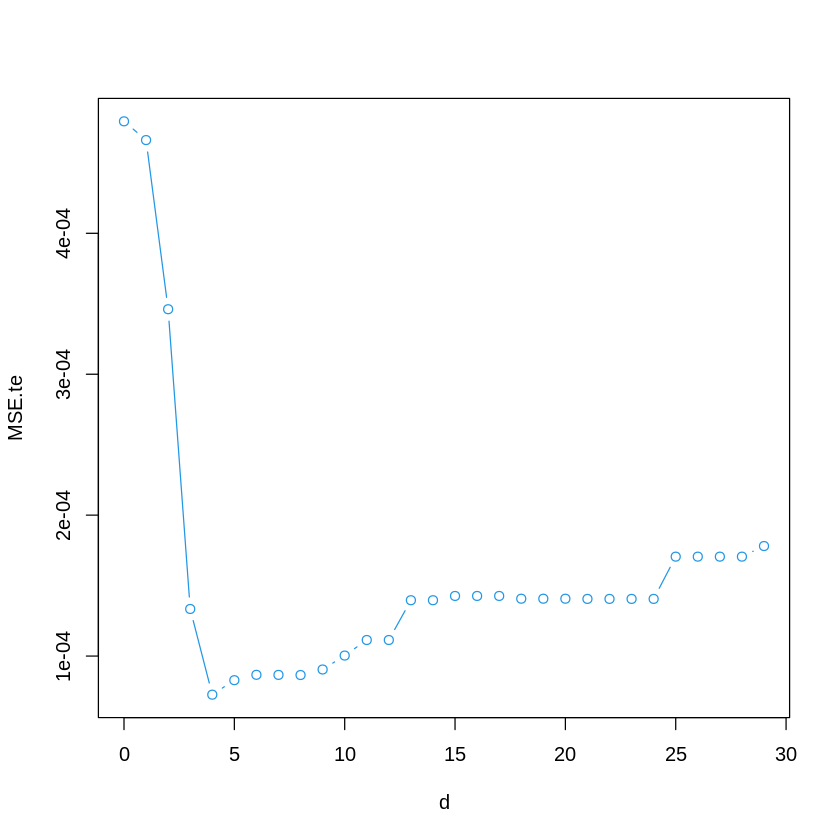

In [7]:
# compute predictions for all degrees
yhats <- lapply(fits, predict)
# compute MSE.te for all degrees
MSEs.te <- unlist(lapply(yhats,
           function(yhat) mean((test$y - yhat)^2))
           )
# plot
plot(ds, MSEs.te, type = "b", col = 4, xlab = "d", ylab = "MSE.te")

In [8]:
# which d gives minimum MSE.te?
ds[which.min(MSEs.te)]

[1] 4

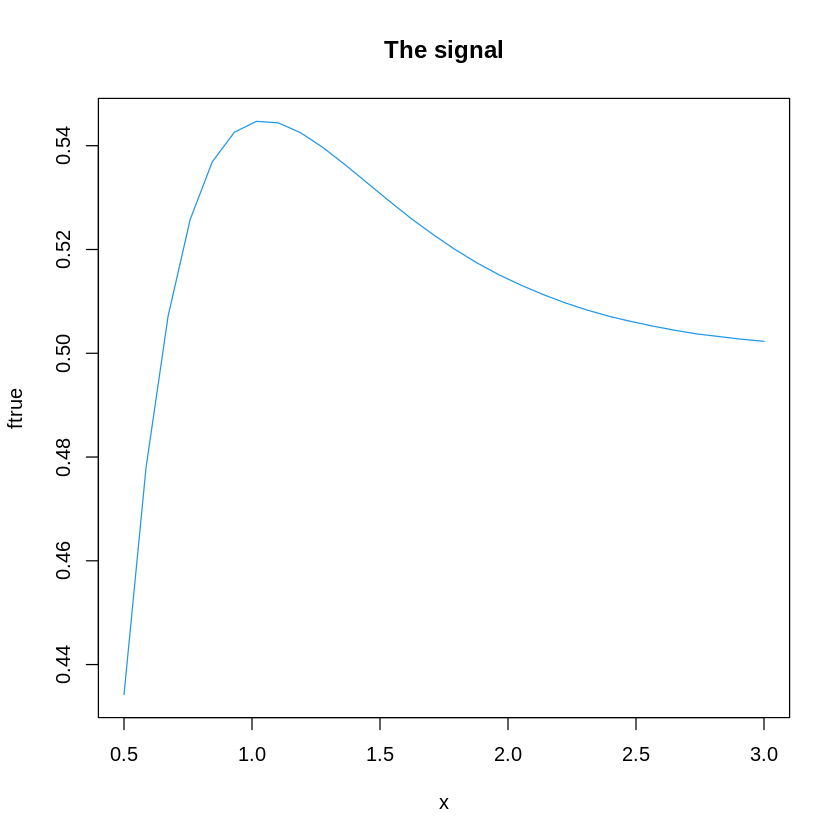

In [9]:
# true regression function
ftrue <- c(0.4342, 0.4780, 0.5072, 0.5258, 0.5369, 0.5426, 0.5447,
           0.5444, 0.5425, 0.5397, 0.5364, 0.5329, 0.5294, 0.5260,
           0.5229, 0.5200, 0.5174, 0.5151, 0.5131, 0.5113, 0.5097,
           0.5083, 0.5071, 0.5061, 0.5052, 0.5044, 0.5037, 0.5032,
           0.5027, 0.5023)
x <- seq(.5, 3, length = 30)
plot(x, ftrue, type = "l", col = 4, main="The signal")

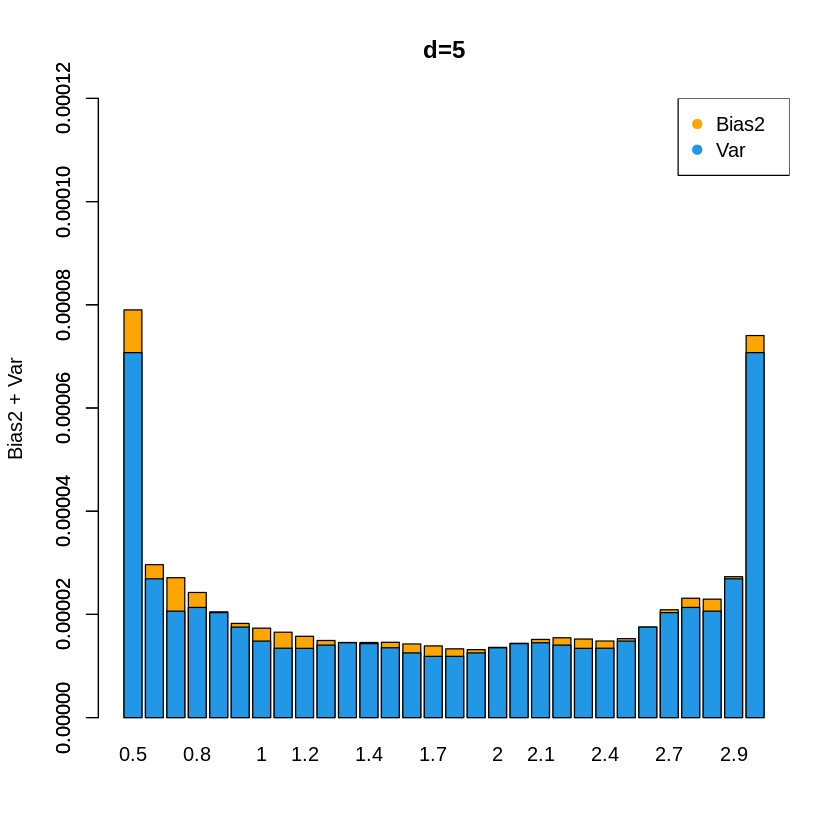

In [19]:
d <- 5
sigmatrue <- 0.01

# design matrix
X <- model.matrix(lm(ftrue ~ poly(x, degree = d)))
invXtX <- solve(crossprod(X))

# Bias
Bias2 <- ( apply(X, 1, function(x)
  x %*% invXtX %*% t(X) %*% ftrue) - ftrue)^2

# Variance
Var <- apply(X, 1, function(x)
  sigmatrue^2 * t(x) %*% invXtX %*% x
)

barplot(Bias2 + Var, ylab = "Bias2 + Var", names.arg = round(x, 1),
        col = "orange", ylim=c(0,0.00012), main="d=5")
barplot(Var, add = T, col = 4, names.arg=" ")
legend("topright", c("Bias2", "Var"), col=c("orange", 4),
       pch = c(19, 19))

In [11]:
# Expected prediction error
# MSE.te theoretical
sigmatrue^2 + mean( Bias2 ) + mean( Var )

[1] 0.0001217199

In [12]:
# via simulation
ErrF = function(d){
  y = ftrue + rnorm(n,0,sigmatrue)
  fit = lm(y ~ poly(x,degree=d))
  yhat = fitted(fit)
  y_new = ftrue + rnorm(n,0,sigmatrue)
  MSE.te = mean( (yhat - y_new)^2 )
}
B = 1000
set.seed(123)

# MSE.te empirical
d <- 5
mean(replicate(B, ErrF(d=5)))

[1] 0.0001221817

# SIM

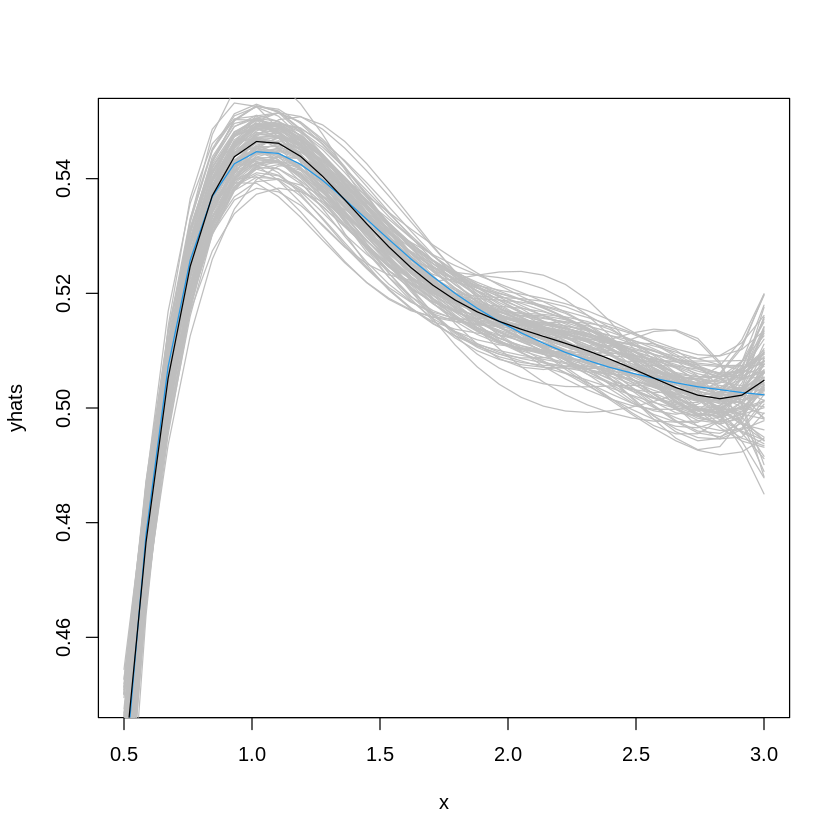

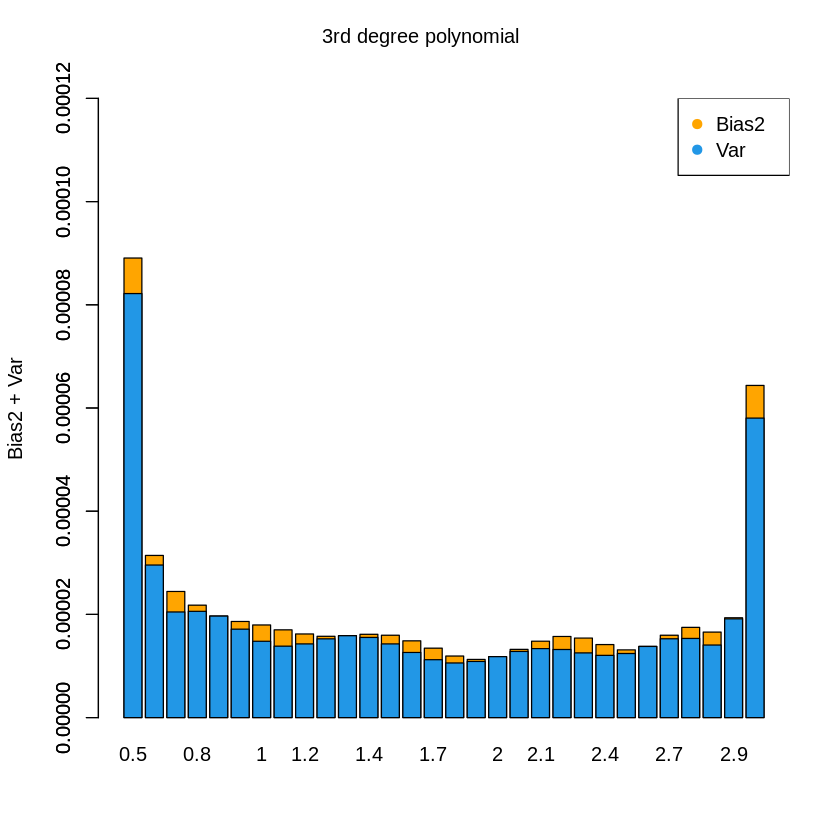

In [13]:
# setting
n <- length(x)
d <- 5
p <- d + 1
B <- 100
# simulation function
sim <- function(d){
       y    <- ftrue + rnorm(n, 0, sigmatrue)
       fit  <- lm(y ~ poly(x, degree = d))
       yhat <- fitted(fit)
}

# results
set.seed(123)
yhats <- replicate(B,sim(d))
matplot(x,yhats, type="l", col="gray", lty=1, ylim=c(.45,.55))
lines(x,ftrue, col=4)

# expected value
Ave <- apply(yhats, 1, mean)
lines(x, Ave)

# squared bias
Bias2 <- (ftrue - Ave)^2
# variance
Var <- apply(yhats, 1, var)

# The bias-variance decomposition gives
barplot(Bias2 + Var, ylab = "Bias2 + Var", names.arg = round(x, 1),
        col = c("orange"), main = " ", ylim=c(0,0.00012))
barplot(Var, add = T, col = 4, names.arg = " ")
legend("topright", c("Bias2","Var"), col = c("orange", 4), pch = c(19, 19))
mtext("3rd degree polynomial", side = 3, line = -2, outer = TRUE)

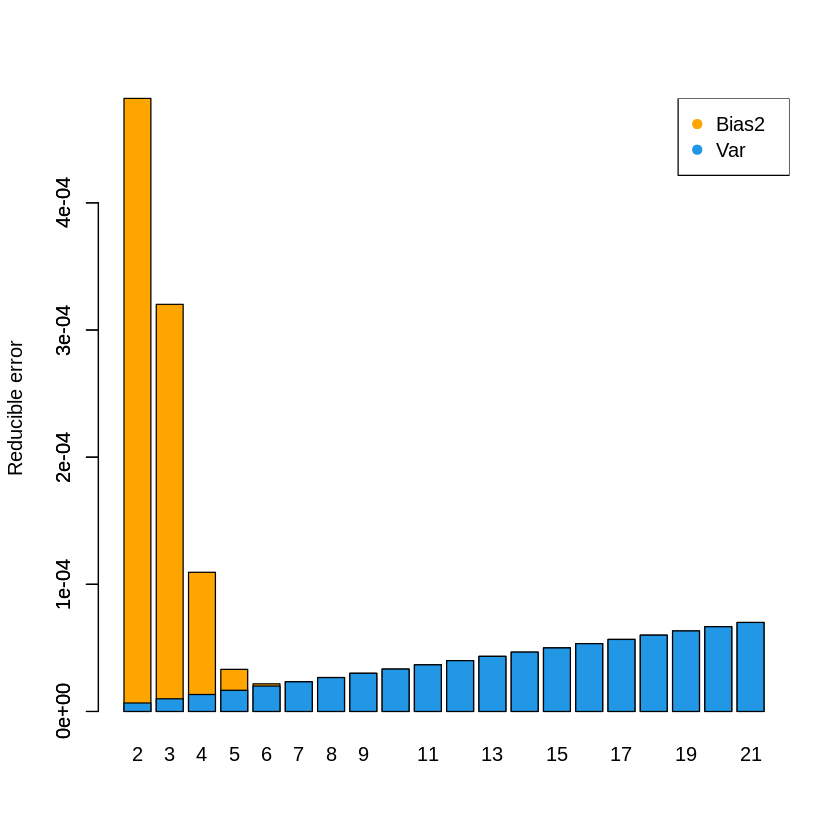

In [14]:
ds <- 1:20
ps <- ds+1

Bias2s <- sapply(ps, function(p)
  mean( ( ftrue - fitted(lm(ftrue ~ poly(x, degree = (p - 1)))) )^2 )
  )
Vars <- ps * (sigmatrue^2) / n
Reds <- Bias2s + Vars

barplot(Reds, ylab = "Reducible error", names.arg = ps, col = "orange")
barplot(Vars, add = T, col = 4, names.arg = " ")
legend("topright", c("Bias2", "Var"), col = c("orange", 4), pch = c(19, 19))

In [15]:
# best model size
ds[which.min(Reds)]
## [1] 5

[1] 5

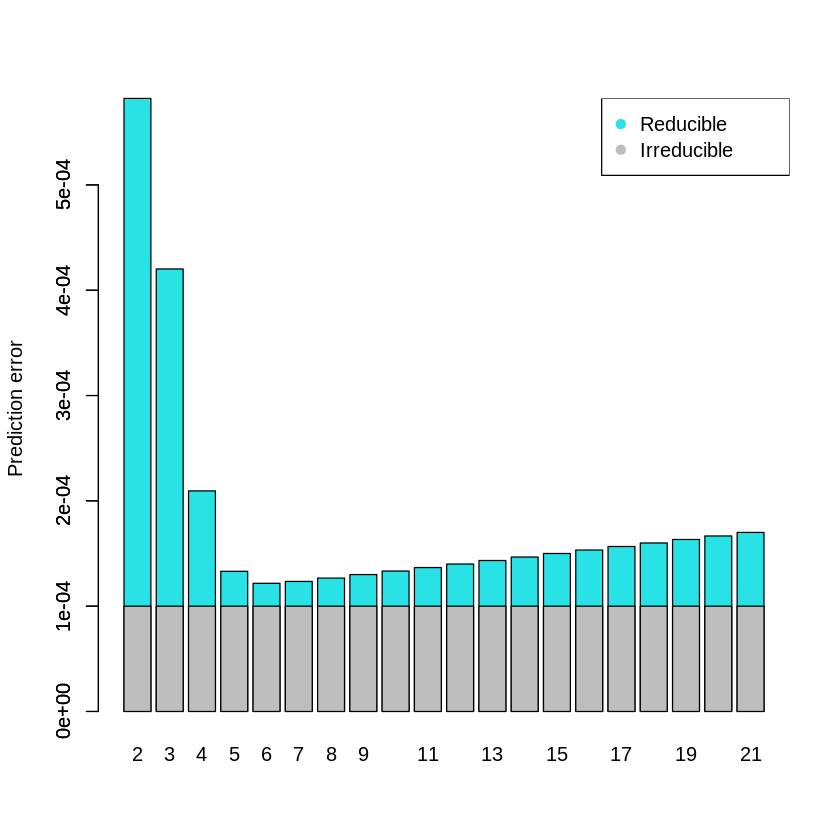

In [16]:
# prediction error
Irr <- rep(sigmatrue^2, length(ps))
ErrFs <- Reds + Irr
barplot(ErrFs, ylab = "Prediction error", names.arg = ps, col = 5)
barplot(Irr, add = T, col = "gray", names.arg = " ")
legend("topright", c("Reducible", "Irreducible"), col = c(5, "gray"), pch = c(19, 19) )

# Exercise

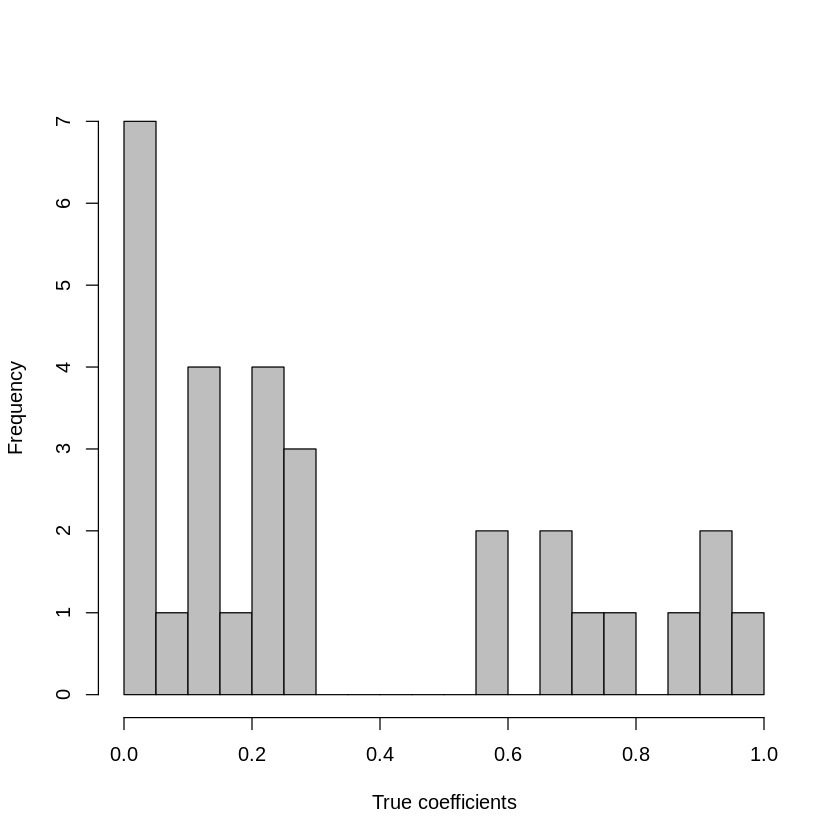

In [22]:
set.seed(0)
n = 50
p = 30
X = matrix(rnorm(n*p),nrow=n)

bstar = c(runif(10,0.5,1),runif(20,0,0.3)) # oracle
mu = as.numeric(X%*%bstar)

hist(bstar,breaks=30,col="gray",main="",
xlab="True coefficients")

# Solution

In [37]:
error_variance = 1
error_mean = 0
d = 2

## First question
Generate a response vector y

In [38]:
y = rnorm(n, mean = 0, sd = error_variance) + mu

In [47]:
regression = lm(y ~ X)
regression


Call:
lm(formula = y ~ X)

Coefficients:
(Intercept)           X1           X2           X3           X4           X5  
   -0.47394      0.52903      1.44324      0.29578      0.61525      0.62025  
         X6           X7           X8           X9          X10          X11  
    1.19157      1.12299      0.41598      0.74152      0.97923      0.08598  
        X12          X13          X14          X15          X16          X17  
    0.33966     -0.01962      0.11040      0.19635      0.16520     -0.08381  
        X18          X19          X20          X21          X22          X23  
    0.31962      0.10344     -0.11677     -0.08981      0.04625      0.62800  
        X24          X25          X26          X27          X28          X29  
    0.29297     -0.05566      0.23672      0.02143      0.59345      0.14373  
        X30  
    0.15929  


In [48]:
fitted(regression)

1          2          3          4          5          6          7 
-1.8072088  0.6444819  4.5882348  3.4335892  1.8682888 -5.2988496 -1.6235288 
         8          9         10         11         12         13         14 
 2.2612255 -4.3878401  0.7700035  1.9607703  0.9115230 -4.1236903  2.5456794 
        15         16         17         18         19         20         21 
 0.5067658  7.5288842 -5.0052907 -2.3166857 -1.6854324 -2.7982259  0.3141388 
        22         23         24         25         26         27         28 
 0.9694441 -3.8364295 -5.3374597  1.8038284  4.9627140  1.8228295  0.7890248 
        29         30         31         32         33         34         35 
-9.2927918 -4.8122007 -2.9671134 -1.4414076 -2.2658549  0.8598349  0.8362707 
        36         37         38         39         40         41         42 
 1.1475877  3.1638006 -2.6216346 -1.7949503 -0.4095623  7.3896184  1.5360511 
        43         44         45         46         47         48         49 
-0.7850294 -2.3597160 -3.3151800 -0.6939105 -2.9416504 -0.3933965  1.5219950 
        50 
-2.4837098

In [49]:
y

[1] -2.18363660  0.74209713  3.69613638  3.81248995  2.53142321 -5.11865767
 [7] -0.73342412  1.72044326 -4.39230113  0.88013657  2.88990071  0.56921718
[13] -4.35180718  2.18828576  1.28517047  7.74574512 -4.83008309 -2.00905634
[19] -0.95404970 -3.27317103 -0.15380827 -0.04394832 -3.84782053 -4.68127612
[25]  1.99371391  6.03064243  1.42124518  0.78628611 -9.59324324 -4.88929572
[31] -2.73509258 -2.26679941 -1.70511596  1.24638894 -0.00799289  0.78897213
[37]  2.18613119 -2.69964392 -2.02008078 -1.22997326  8.17229198  1.56596398
[43] -0.64152697 -3.10871238 -2.46283462 -1.45273775 -2.92010244 -0.45148723
[49]  1.35406661 -1.51123408